In [28]:
import pandas as pd

df_all_messages = pd.read_excel('messages0721.xlsx')
df_all_catalysts = pd.read_excel('catalyst0721.xlsx')


In [29]:
import pandas as pd
import os

def build_usage_df(messages_path, catalysts_path=None):
    df = pd.read_excel(messages_path)

    if catalysts_path and os.path.exists(catalysts_path):
        df2 = pd.read_excel(catalysts_path)

        # 동일 구조로 변환
        df_columns = df.columns
        df2_like_df = pd.DataFrame(columns=df_columns)
        df2_like_df['User Email'] = df2['User Email']
        df2_like_df['Created At'] = df2['Created At']
        df2_like_df['Organization'] = df2['Organization']  # 필수!

        df = pd.concat([df, df2_like_df], ignore_index=True)

    # 유저 이름 매핑
    email_to_name = df.loc[df['User Name'].notna(), ['User Email', 'User Name']] \
                      .drop_duplicates() \
                      .set_index('User Email')['User Name'].to_dict()

    df['User Name'] = df.apply(
        lambda row: email_to_name.get(row['User Email'], row['User Name']),
        axis=1
    )

    # 기본 컬럼 처리
    df['Function Mode'] = df.get('Function Mode', 'catalysts').fillna('catalysts')
    df['Sender'] = df.get('Sender', 'user').fillna('user')
    df.columns = df.columns.str.lower().str.replace(' ', '_')

    df = df[df['sender'] == 'user']
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['status'] = 'active'

    return df


In [30]:
import pandas as pd

# ✅ usage 통합 데이터프레임
df_all = build_usage_df("messages0721.xlsx", "catalyst0721.xlsx")
df_all['user_email'] = df_all['user_email'].str.strip().str.lower()

# ✅ users.xlsx 파일 로딩
users_xlsx = pd.ExcelFile('users.xlsx')
all_sheet_names = users_xlsx.sheet_names

# ✅ CLSA 관련 division 데이터 병합용으로 따로 모두 수집
df_div_joined = pd.read_excel(users_xlsx, sheet_name='clsa')
df_div_invited = pd.read_excel(users_xlsx, sheet_name='clsa_invited')

for df in [df_div_joined, df_div_invited]:
    df['user_email'] = df['user_email'].str.strip().str.lower()
    df['division'] = df['division'].astype(str).str.strip()

# ✅ 두 시트 병합 → email-division 매핑 테이블 생성
email_div_map = pd.concat([
    df_div_joined[['user_email', 'division']],
    df_div_invited[['user_email', 'division']]
], ignore_index=True).dropna(subset=['user_email', 'division']).drop_duplicates()

# ✅ 1️⃣ joined 병합
for sheet_name in all_sheet_names:
    if "_invited" in sheet_name:
        continue

    try:
        df_joined = pd.read_excel(users_xlsx, sheet_name=sheet_name)
        df_joined['user_email'] = df_joined['user_email'].str.strip().str.lower()

        org_matches = df_all['organization'].dropna().unique()
        org_matched = next((org for org in org_matches if sheet_name.lower() in org.lower()), None)

        if not org_matched:
            print(f"[{sheet_name}] organization 매칭 실패 (joined)")
            continue

        df_usage = df_all[df_all['organization'] == org_matched]
        used_emails = set(df_usage['user_email'].unique())
        joined_no_usage = df_joined[~df_joined['user_email'].isin(used_emails)].copy()

        df_missing = pd.DataFrame(columns=df_all.columns)
        for col in ['user_email', 'user_name', 'organization']:
            if col in df_missing.columns and col in joined_no_usage.columns:
                df_missing[col] = joined_no_usage[col].values

        df_missing['status'] = 'joined_no_usage'
        df_missing['organization'] = org_matched

        df_all = pd.concat([df_all, df_missing], ignore_index=True)

    except Exception as e:
        print(f"[{sheet_name}] joined 병합 실패: {e}")

# ✅ 2️⃣ invited 병합
for sheet_name in all_sheet_names:
    if not sheet_name.endswith("_invited"):
        continue

    try:
        df_invited = pd.read_excel(users_xlsx, sheet_name=sheet_name)
        df_invited['user_email'] = df_invited['user_email'].str.strip().str.lower()

        company_base = sheet_name.replace("_invited", "")
        org_matches = df_all['organization'].dropna().unique()
        org_matched = next((org for org in org_matches if company_base.lower() in org.lower()), None)

        if not org_matched:
            print(f"[{sheet_name}] organization 매칭 실패 (invited)")
            continue

        df_missing = pd.DataFrame(columns=df_all.columns)
        for col in ['user_email', 'organization', 'status']:
            if col in df_missing.columns and col in df_invited.columns:
                df_missing[col] = df_invited[col].values

        df_missing['status'] = 'invited_not_joined'
        df_missing['organization'] = org_matched

        df_all = pd.concat([df_all, df_missing], ignore_index=True)

    except Exception as e:
        print(f"[{sheet_name}] invited 병합 실패: {e}")

# ✅ CLSA division 병합 (joined + invited 기반으로 만든 전체 테이블)
try:
    df_all = df_all.merge(email_div_map, on='user_email', how='left', suffixes=('', '_new'))
    df_all['division'] = df_all['division'].combine_first(df_all['division_new'])
    df_all.drop(columns=['division_new'], inplace=True)
except Exception as e:
    print(f"[CLSA] division 병합 실패: {e}")

# ✅ earnings/briefing 정보 수집 및 컬럼 추가
email_feature_map = {}
for sheet_name in all_sheet_names:
    if "_invited" in sheet_name:  # invited 시트는 건너뛰기
        continue
        
    try:
        df_sheet = pd.read_excel(users_xlsx, sheet_name=sheet_name)
        df_sheet['user_email'] = df_sheet['user_email'].str.strip().str.lower()
        
        # earnings와 briefing 정보 수집
        for feature in ['earnings', 'briefing']:
            if feature in df_sheet.columns:
                for email, status in df_sheet[['user_email', feature]].values:
                    if pd.notna(email):
                        if email not in email_feature_map:
                            email_feature_map[email] = {}
                        if pd.notna(status):  # status가 있을 때만 저장
                            email_feature_map[email][feature] = status
                        
    except Exception as e:
        print(f"[{sheet_name}] feature 정보 수집 실패: {e}")

# earnings/briefing 컬럼 추가
df_all['earnings'] = df_all['user_email'].map(lambda x: email_feature_map.get(x, {}).get('earnings', None))
df_all['briefing'] = df_all['user_email'].map(lambda x: email_feature_map.get(x, {}).get('briefing', None))

# ✅ 저장
df_all.to_csv("df_all.csv", index=False)

[cgsi] organization 매칭 실패 (joined)
[panvira] organization 매칭 실패 (joined)
[rocksprings] organization 매칭 실패 (joined)
[turiya] organization 매칭 실패 (joined)
[cgsi_invited] organization 매칭 실패 (invited)
[panvira_invited] organization 매칭 실패 (invited)
[rocksprings_invited] organization 매칭 실패 (invited)
[CLSA] division 병합 실패: 'division_new'


/var/folders/l1/ktg7ylkj42q3hp4jh40_3_xc0000gq/T/ipykernel_1831/1880408021.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df2_like_df], ignore_index=True)
/var/folders/l1/ktg7ylkj42q3hp4jh40_3_xc0000gq/T/ipykernel_1831/325205943.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_all, df_missing], ignore_index=True)
/var/folders/l1/ktg7ylkj42q3hp4jh40_3_xc0000gq/T/ipykernel_1831/325205943.py:53: FutureWarning: The behavior of DataFrame concatenat

처리 전 전체 데이터 수: 2034

각 조건에 해당하는 데이터 수:
음수 값: 4
0값: 0
5분 이상: 94

처리 후 통계:
count      1309.000000
mean      42838.188694
std       37732.328800
min        3060.000000
25%       21684.000000
50%       28865.000000
75%       46866.000000
max      285718.000000
Name: time_to_first_byte, dtype: float64

최종 결과:
null 값 개수: 725
유효한 데이터 수: 1309


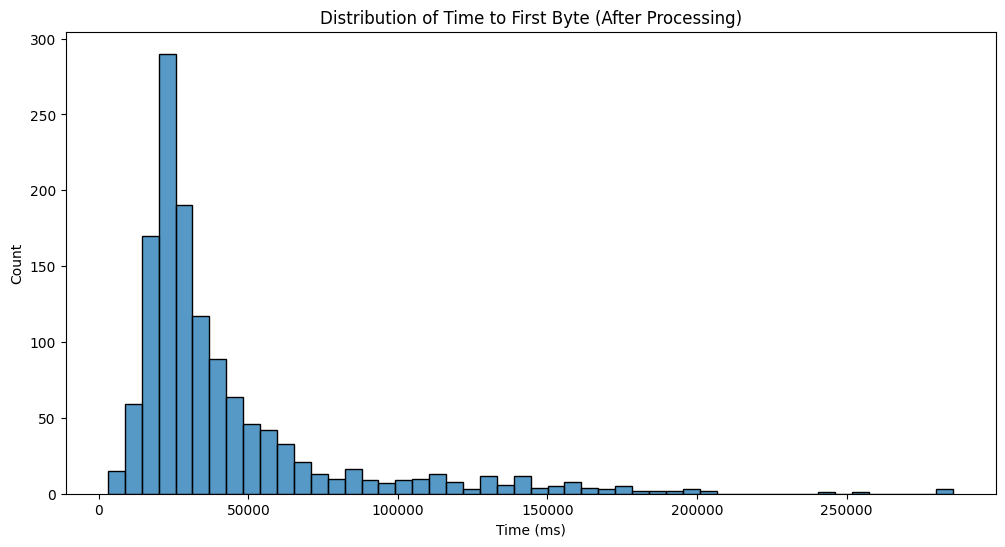

In [33]:
# 원본 데이터 개수 출력
print("처리 전 전체 데이터 수:", len(df_all))

# 조건에 맞는 데이터 개수 확인
print("\n각 조건에 해당하는 데이터 수:")
print("음수 값:", df_all[df_all['time_to_first_byte'] < 0].shape[0])
print("0값:", df_all[df_all['time_to_first_byte'] == 0].shape[0])
print("5분 이상:", df_all[df_all['time_to_first_byte'] > 300000].shape[0])

# 값 변경 (null로 설정)
df_all.loc[df_all['time_to_first_byte'] <= 0, 'time_to_first_byte'] = None  # 0 이하 제거
df_all.loc[df_all['time_to_first_byte'] > 300000, 'time_to_first_byte'] = None  # 5분 초과 제거

# 처리 후 통계
print("\n처리 후 통계:")
print(df_all['time_to_first_byte'].describe())

# null이 된 개수와 남은 유효한 데이터 개수 확인
print("\n최종 결과:")
print("null 값 개수:", df_all['time_to_first_byte'].isna().sum())
print("유효한 데이터 수:", df_all['time_to_first_byte'].notna().sum())

# 히스토그램으로 확인
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(data=df_all, x='time_to_first_byte', bins=50)
plt.title('Distribution of Time to First Byte (After Processing)')
plt.xlabel('Time (ms)')
plt.show()

In [34]:
df_all.earnings.value_counts()

earnings
onboarded    896
Name: count, dtype: int64

In [35]:
df_all.briefing.value_counts()

briefing
onboarded    670
Name: count, dtype: int64

In [3]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2034 entries, 0 to 2033
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  1952 non-null   object 
 1   selected_model      1952 non-null   object 
 2   sender              2014 non-null   object 
 3   function_mode       2014 non-null   object 
 4   user_name           2017 non-null   object 
 5   user_email          2034 non-null   object 
 6   user_group          1952 non-null   object 
 7   organization        2034 non-null   object 
 8   time_to_first_byte  1407 non-null   float64
 9   created_at          2014 non-null   object 
 10  status              2034 non-null   object 
 11  division            106 non-null    object 
 12  earnings            896 non-null    object 
 13  briefing            670 non-null    object 
dtypes: float64(1), object(13)
memory usage: 222.6+ KB
